# Comparing SODA an WOA datasets
for model validation

# <span style='color:Green'> SODA 3.4.2

In [13]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [14]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.456bb54e74d04c8987c3ffef60d83951 Dashboard: /services/dask-gateway/clusters/staging.456bb54e74d04c8987c3ffef60d83951/status,Cluster Workers: 8 Cores: 16 Memory: 64.00 GiB


In [34]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import gsw
from xhistogram.xarray import histogram
import fastjmd95 

In [2]:
xr.set_options(display_style='text')

In [5]:
woa_8110 = xr.open_dataarray('/home/jovyan/WMT-project/WOA/ts_hist_8110.nc')
woa_0517 = xr.open_dataarray('/home/jovyan/WMT-project/WOA/ts_hist_0517.nc')

In [17]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)
cells = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/cells_wg.zarr'))
#with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
#    topo = xr.open_dataset(fp)

In [18]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [9]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [10]:
ds_wg = ocean.isel(**lat_range, **lon_range)

In [58]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

In [22]:
#salt_bins = np.linspace(31.5, 35.5, 100)
#theta_bins = np.linspace(-2, 4, 100)
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = cells.dx_interp * cells.dy_u * cells.dz

In [37]:
pref=2000
sigma2 = fastjmd95.rho(salt, temp, pref)
# define bins (ECCO & SOSE bin size 1000)
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [43]:
histogram(sigma2.rename('sigma2'), bins=[sigma_bins], 
          weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean'])

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
dask.array<getitem, shape=(1970, 699), dtype=float64, chunksize=(1, 699), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

In [57]:
temp.map_blocks()

<xarray.DataArray 'temp' (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<getitem, shape=(1970, 50, 169, 381), dtype=float32, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [60]:
ts_hist = histogram(temp_mask, salt_mask, 
                    bins=[theta_bins, salt_bins],
                    weights=vol, 
                    dim=['xt_ocean', 'yt_ocean', 'st_ocean']).rename({'THETA_bin':'theta_bin',
                                                              'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

AttributeError: 'list' object has no attribute 'map_blocks'

In [15]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

# <span style='background :yellow'> Difference between ECCO and WOA (1981-2010) </span>

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


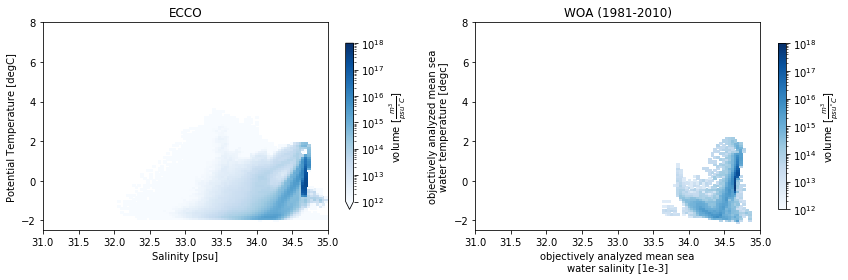

In [5]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

ecco.where(ecco>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('ECCO')

woa_8110.where(woa_8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (1981-2010)')

plt.tight_layout();